In [1]:
import pandas as pd
import numpy as np
import math
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import statistics
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

file_name = "/content/drive/My Drive/Subjects/"
file_name1 = '/content/drive/My Drive/Subjects/Ambient/Ambient/'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### merging function

In [3]:
def merge(k):
  #### reading datasets
  HR = pd.read_csv(file_name + str(k) + '/HR.csv',header = None)
  HR_median = pd.read_csv(file_name + str(k) + '/HR_median.csv',header = None)
  EDA = pd.read_csv(file_name + str(k) + '/EDA_envelope.csv', header = None)
  TEMP = pd.read_csv(file_name + str(k) + '/TEMP.csv', header = None)
  BVP = pd.read_csv(file_name + str(k) + '/BVP.csv', header = None)
  BVP_envelope = pd.read_csv(file_name + str(k) + '/BVP_envelope.csv', header = None)
  BVP_median = pd.read_csv(file_name + str(k) + '/BVP_median.csv', header = None)
  Ambient = pd.read_csv(file_name1 + str(k) + '_Env_1.txt',sep = ' ',header = None)

  #### removing first two rows that show start timestamp and frequency
  HR_starttime = int(HR.iloc[0])
  HR_fq = HR.iloc[1]
  HR = HR.rename(columns = {0 : "HR"})

  EDA_starttime = int(TEMP.iloc[0])
  EDA_fq = 4
  EDA = EDA.rename(columns = {0 : "EDA"})

  TEMP_starttime = int(TEMP.iloc[0])
  TEMP_fq = TEMP.iloc[1]
  TEMP = TEMP.rename(columns = {0 : "TEMP"})

  BVP_starttime = int(BVP.iloc[0])
  BVP_fq = BVP.iloc[1]
  BVP = BVP.rename(columns = {0 : "BVP"})

  MAX = max(HR_starttime,EDA_starttime,BVP_starttime,TEMP_starttime)
  HR_dif = MAX - HR_starttime
  EDA_dif = MAX - EDA_starttime
  BVP_dif = MAX - BVP_starttime
  TEMP_dif = MAX - TEMP_starttime

  if HR_dif > 0:
      HR = HR.drop(range(2,int(HR_dif*HR_fq)))
      HR_median = HR_median.drop(range(2,int(HR_dif*HR_fq)))
  if EDA_dif > 0:
      EDA = EDA.drop(range(2,int(EDA_dif*EDA_fq)))
  if BVP_dif > 0 :
      BVP = BVP.drop(range(2,int(BVP_dif * BVP_fq)))
      BVP_median = BVP_median.drop(range(2,int(BVP_dif * BVP_fq)))
      BVP_envelope = BVP_envelope.drop(range(2,int(BVP_dif * BVP_fq)))
  if TEMP_dif > 0 :
      TEMP = TEMP.drop(range(2,int(TEMP_dif*TEMP_fq)))

  #### removing first 3 mintutes of the experience for each subject
  EDA = EDA.reset_index()
  EDA = EDA.drop(range(0,int(180 * EDA_fq)))
  EDA = pd.DataFrame(EDA)
  EDA = EDA.drop(columns = "index")

  HR = HR.reset_index()
  HR = HR.drop(range(0,int(180 * HR_fq)))
  HR = pd.DataFrame(HR)
  HR = HR.drop(columns = "index")

  HR_median = HR_median.reset_index()
  HR_median = HR_median.drop(range(0,int(180 * HR_fq)))
  HR_median = pd.DataFrame(HR_median)
  HR_median = HR_median.drop(columns = "index")

  TEMP = TEMP.reset_index()
  TEMP = TEMP.drop(range(0,int(180 * TEMP_fq)))
  TEMP = pd.DataFrame(TEMP)
  TEMP= TEMP.drop(columns = "index")

  BVP = BVP.reset_index()
  BVP = BVP.drop(range(0,int(180 * BVP_fq)))
  BVP = pd.DataFrame(BVP)
  BVP= BVP.drop(columns = "index")

  BVP_envelope = BVP_envelope.reset_index()
  BVP_envelope = BVP_envelope.drop(range(0,int(180 * BVP_fq)))
  BVP_envelope = pd.DataFrame(BVP_envelope)
  BVP_envelope= BVP_envelope.drop(columns = "index")

  BVP_median = BVP_median.reset_index()
  BVP_median = BVP_median.drop(range(0,int(180 * BVP_fq)))
  BVP_median = pd.DataFrame(BVP_median)
  BVP_median= BVP_median.drop(columns = "index")

  if k in [25,32,33,63,66,76]:
    Ambient = pd.read_csv(file_name1 + str(k) + '_Env_1.txt',sep = ',')
    Ambient.columns = ["time", "Ambient_Temp"]
    # Ambient = Ambient.drop(Ambient["time"][Ambient["time"] < 90].index)
    # Ambient = Ambient.reset_index()
    # Ambient = Ambient.drop(columns = ["index"])
  else:
    Ambient.columns = ("Day","Hour","Humidity","Ambient_Temp","unknown")
    Ambient['Hour']  = pd.to_datetime(Ambient['Hour'])
    Ambient['time'] = Ambient['Hour'] - Ambient.iloc[0,1]
    Ambient['time'] = Ambient['time'].dt.total_seconds().astype(int)
    Ambient = Ambient.dropna()
    Ambient = Ambient.reset_index()
    Ambient = Ambient.drop(columns = ["unknown","index","Day","Hour","Humidity"])
    Ambient = Ambient.drop(Ambient["time"][Ambient["time"] < 90].index)
    Ambient = Ambient.reset_index()
    Ambient = Ambient.drop(columns = ["index"])

  #### only focus on the ascending trend of the ambient temperature
  Upper_head = Ambient["time"][Ambient["Ambient_Temp"] == Ambient["Ambient_Temp"].max()].max()

  if k == 35:
    Upper_head = 5300

  Ambient = Ambient.drop(range(math.floor(Upper_head/2),Ambient.shape[0]))
  Ambient = Ambient.reset_index()
  Ambient = Ambient.drop(columns = ["index"])

  EDA = EDA.reset_index()
  EDA = EDA.drop(range(int(Upper_head*EDA_fq),EDA.shape[0]))
  EDA = pd.DataFrame(EDA)
  EDA = EDA.drop(columns = "index")

  HR = HR.reset_index()
  HR = HR.drop(range(int(Upper_head*HR_fq),HR.shape[0]))
  HR = pd.DataFrame(HR)
  HR = HR.drop(columns = "index")

  HR_median = HR_median.reset_index()
  HR_median = HR_median.drop(range(int(Upper_head*HR_fq),HR_median.shape[0]))
  HR_median  = pd.DataFrame(HR_median)
  HR_median = HR_median.drop(columns = "index")

  TEMP = TEMP.reset_index()
  TEMP = TEMP.drop(range(int(Upper_head*TEMP_fq),TEMP.shape[0]))
  TEMP = pd.DataFrame(TEMP)
  TEMP = TEMP.drop(columns = "index")

  BVP = BVP.reset_index()
  BVP = BVP.drop(range(int(Upper_head*BVP_fq),BVP.shape[0]))
  BVP = pd.DataFrame(BVP)
  BVP= BVP.drop(columns = "index")

  BVP_envelope = BVP_envelope.reset_index()
  BVP_envelope = BVP_envelope.drop(range(int(Upper_head*BVP_fq),BVP_envelope.shape[0]))
  BVP_envelope = pd.DataFrame(BVP_envelope)
  BVP_envelope = BVP_envelope.drop(columns = "index")

  BVP_median = BVP_median.reset_index()
  BVP_median = BVP_median.drop(range(int(Upper_head*BVP_fq),BVP_median.shape[0]))
  BVP_median = pd.DataFrame(BVP_median)
  BVP_median = BVP_median.drop(columns = "index")

  #### assigning time to each feature
  HR['time'] = list(np.arange(0, int(Upper_head * HR_fq),float(1/HR_fq)))
  HR_median['time'] = list(np.arange(0, int(Upper_head * HR_fq),float(1/HR_fq)))
  HR_median.columns = ["HR_median", "time"]
  EDA['time'] = list(np.arange(0, int(Upper_head),float(1/EDA_fq)))
  TEMP['time'] = list(np.arange(0, int(Upper_head),float(1/TEMP_fq)))
  BVP['time'] = list(np.arange(0, int(Upper_head),float(1/64)))
  BVP_envelope['time'] = list(np.arange(0, int(Upper_head),float(1/64)))
  BVP_median['time'] = list(np.arange(0, int(Upper_head),float(1/64)))

  #### preparing BVPs
  temp = pd.DataFrame(BVP["BVP"].groupby(np.arange(len(BVP["BVP"]))//1024).std())
  time = pd.DataFrame(BVP["time"].groupby(np.arange(len(BVP["time"]))//1024).median().round())
  BVP = pd.concat([time,temp],axis = 1)

  BVP_envelope.columns = ["BVP_envelope", "time"]
  time = pd.DataFrame(list(np.arange(0, int(Upper_head),float(1/4))))
  BVP_envelope = BVP_envelope["BVP_envelope"].groupby(np.arange(len(BVP_envelope["BVP_envelope"]))//16).mean()
  BVP_envelope = pd.concat([time,BVP_envelope],axis = 1)
  BVP_envelope.columns = ["time", "BVP_envelope"]

  BVP_median.columns = ["BVP_median", "time"]
  BVP_median = pd.DataFrame(BVP_median)
  BVP_median = BVP_median["BVP_median"].groupby(np.arange(len(BVP_median["BVP_median"]))//16).mean()
  BVP_median = pd.concat([time, BVP_median], axis=1)
  BVP_median.columns = ["time","BVP_median"]


  #merging all datasess
  Dataset = EDA.merge(HR,on = "time", how='outer')
  Dataset = Dataset.merge(HR_median,on = "time", how='outer')
  Dataset['HR'] = Dataset['HR'].interpolate()
  Dataset['HR_median'] = Dataset['HR_median'].interpolate()

  Dataset = Dataset.merge(TEMP, on = "time", how = 'outer')

  Dataset = Dataset.merge(BVP, on = "time", how = 'outer')
  Dataset['BVP'] = Dataset['BVP'].interpolate()
  Dataset = Dataset.merge(BVP_envelope, on = "time", how = 'outer')
  Dataset = Dataset.merge(BVP_median, on = "time", how = 'outer')

  Ambient['time'] = list(np.arange(0,Upper_head-1,2))
  Dataset = Dataset.merge(Ambient, on = "time", how = 'outer')
  Dataset['Ambient_Temp'] = Dataset['Ambient_Temp'].astype(float)
  Dataset['Ambient_Temp'] = Dataset['Ambient_Temp'].interpolate()

  if k in [25,32,33,35,63,66,69,76]:
    TV = pd.read_csv(file_name + str(k) + '/' + str(k) + '_votes&ambient.csv')
    TV["time"] = TV["Unnamed: 0"]*60
    TV = TV.drop(["Time", "Unnamed: 0"],axis=1)
  else:
    TV = pd.read_csv(file_name + str(k) + '/' + str(k) + '_votes&ambient.csv')
    TV["time"] = TV["Unnamed: 0"]*2
    TV = TV.drop(["Time", "Unnamed: 0"],axis=1)

  Dataset = Dataset.merge(TV, on = "time", how = 'outer')
  Dataset['Thermal Preference'] = Dataset['Thermal Preference'].interpolate()
  Dataset["Thermal Preference"][(Dataset["Thermal Preference"] <= 1) & (Dataset["Thermal Preference"] >= -1)] = 0
  #Dataset["Thermal Preference"][(Dataset["Thermal Preference"] > 1) | (Dataset["Thermal Preference"] < -1)] = 1
  Dataset["Thermal Preference"][Dataset["Thermal Preference"] > 1] = 1
  Dataset["Thermal Preference"][Dataset["Thermal Preference"] < -1] = -1
  Dataset = Dataset.dropna()

  # Changing to minute based!
  Dataset = Dataset.groupby(np.arange(len(Dataset["BVP_envelope"]))//240).mean()
  return Dataset

### Analysis for each question

#### Q1: How the features from this device reflect the change in the ambient conditions

##### Correlation Matrix

In [4]:
Cor = pd.DataFrame()
Cor["Subject"] = range(0,100)
Cor["EDA"] = 0
Cor["HR"] = 0
Cor["HR_median"] = 0
Cor["TEMP"] = 0
Cor["BVP"] = 0
Cor["BVP_median"] = 0
Cor["BVP_envelope"] = 0
Cor["Thermal Preference"] = 0

In [5]:
feature = "Thermal Preference"
for k in range(0,100):
  try:
    Dataset = merge(k)
    Cor.iloc[k,1] = np.corrcoef(Dataset[feature],Dataset["EDA"])[1,0]
    Cor.iloc[k,2] = np.corrcoef(Dataset[feature],Dataset["HR"])[1,0]
    Cor.iloc[k,3] = np.corrcoef(Dataset[feature],Dataset["HR_median"])[1,0]
    Cor.iloc[k,4] = np.corrcoef(Dataset[feature],Dataset["TEMP"])[1,0]
    Cor.iloc[k,5] = np.corrcoef(Dataset[feature],Dataset["BVP"])[1,0]
    Cor.iloc[k,6] = np.corrcoef(Dataset[feature],Dataset["BVP_median"])[1,0]
    Cor.iloc[k,7] = np.corrcoef(Dataset[feature],Dataset["BVP_envelope"])[1,0]
    Cor.iloc[k,8] = np.corrcoef(Dataset[feature],Dataset["Thermal Preference"])[1,0]
  except:
    print('there is an error on ',str(k)+"_Env")
    pass

there is an error on  0_Env
there is an error on  1_Env
there is an error on  2_Env
there is an error on  3_Env
there is an error on  4_Env
there is an error on  5_Env
there is an error on  6_Env
there is an error on  7_Env
there is an error on  8_Env
there is an error on  9_Env
there is an error on  10_Env
there is an error on  11_Env
there is an error on  12_Env
there is an error on  13_Env
there is an error on  14_Env
there is an error on  15_Env
there is an error on  16_Env
there is an error on  17_Env
there is an error on  18_Env
there is an error on  19_Env


/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


there is an error on  24_Env
there is an error on  27_Env
there is an error on  30_Env
there is an error on  34_Env
there is an error on  48_Env
there is an error on  49_Env
there is an error on  60_Env
there is an error on  61_Env
there is an error on  62_Env
there is an error on  64_Env
there is an error on  80_Env
there is an error on  81_Env
there is an error on  82_Env
there is an error on  84_Env
there is an error on  85_Env
there is an error on  86_Env
there is an error on  87_Env
there is an error on  88_Env
there is an error on  89_Env
there is an error on  90_Env
there is an error on  91_Env
there is an error on  92_Env
there is an error on  93_Env
there is an error on  94_Env
there is an error on  95_Env
there is an error on  96_Env
there is an error on  97_Env
there is an error on  98_Env
there is an error on  99_Env


In [6]:
Cor = Cor[Cor["HR"] != 0]

In [7]:
Subjects = pd.read_excel(file_name + "Subjects_all.xlsx")

In [8]:
Subjects = Subjects.merge(Cor, on = "Subject")

In [14]:
Subjects.head()

,Subject,Age,Gender,Height,Weight,BMI,EDA,HR,HR_median,TEMP,BVP,BVP_median,BVP_envelope,Thermal Preference
0,20,x,M,70.0,130,18.651020,0.005585,0.218269,-0.528072,-0.275699,-0.182650,-0.528513,0.152875,1.0
1,21,x,M,70.0,130,18.651020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,22,x,M,76.0,175,21.299342,0.384732,-0.601497,-0.649791,-0.506821,-0.442943,-0.036606,0.224180,1.0
3,23,x,F,66.0,140,22.594123,-0.053430,0.156555,0.161540,0.216649,-0.143465,0.142861,-0.308331,1.0
4,25,x,M,72.0,156,21.155093,-0.345815,0.108990,-0.032048,-0.604646,-0.553922,-0.206297,0.421720,1.0


In [19]:
Subjects.describe()

,Subject,Height,Weight,BMI,EDA,HR,HR_median,TEMP,BVP,BVP_median,BVP_envelope,Thermal Preference
count,51.000000,51.000000,51.000000,51.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,4.800000e+01
mean,50.862745,68.495098,157.137255,23.571910,-0.452723,-0.079494,-0.262752,-0.319912,-0.185127,-0.064395,-0.145877,1.000000e+00
std,18.239539,3.661451,27.071032,3.944051,0.437513,0.304804,0.507683,0.591221,0.349384,0.445587,0.511474,7.595785e-17
min,20.000000,61.000000,106.000000,17.069949,-0.920629,-0.833056,-0.958825,-0.905204,-0.796539,-0.748386,-0.932699,1.000000e+00
25%,36.500000,66.000000,137.500000,20.396491,-0.762146,-0.290913,-0.679752,-0.801364,-0.454935,-0.412028,-0.544531,1.000000e+00
50%,51.000000,68.000000,158.000000,23.329973,-0.597921,-0.082022,-0.474229,-0.497843,-0.220681,-0.113400,-0.232303,1.000000e+00
75%,67.500000,71.000000,173.500000,25.344610,-0.349527,0.138691,0.171679,-0.123776,-0.060627,0.266264,0.227548,1.000000e+00
max,83.000000,76.000000,223.000000,33.891185,0.885152,0.589534,0.929035,0.862607,0.744590,0.787047,0.905920,1.000000e+00


In [9]:
Subjects[(Subjects["BMI"] > 24)].shape

(19, 14)

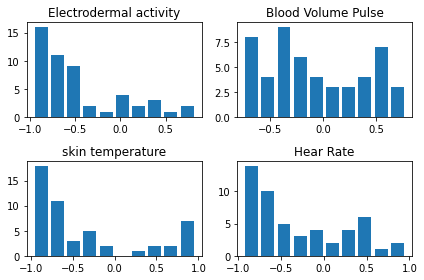

In [ ]:
fig, ax = plt.subplots(2,2)

ax[0,0].hist(Cor["EDA"], rwidth = 0.8)
ax[0,0].set_title('Electrodermal activity')

ax[1,0].hist(Cor["TEMP"], rwidth = 0.8)
ax[1,0].set_title('skin temperature')

ax[0,1].hist(Cor["BVP_median"], rwidth = 0.8)
ax[0,1].set_title('Blood Volume Pulse')

ax[1,1].hist(Cor["HR_median"], rwidth = 0.8)
ax[1,1].set_title('Hear Rate')

fig.tight_layout()
plt.savefig("subplot1.png", dpi = 1000)

##### Comparing heat-flux data and skin temperature for all subjects

In [ ]:
#### we have to make sure about the frequency of ambient temperature and heat flux

In [ ]:
# reading skin temperature from Empatica
k=50
TEMP = pd.read_csv(file_name + str(k) + '/TEMP.csv', header = None)
TEMP = TEMP.drop(range(0,int(60)))
HF = pd.read_excel(file_name + str(k) + '/' + str(k) + '_heatFlux.xlsx',header = None)
HF = HF.drop(range(0,int(60)))

In [ ]:
Ambient = pd.read_csv(file_name1 + str(k) + '_Env_1.txt',sep = ' ',header = None)
#Ambient = Ambient[3]

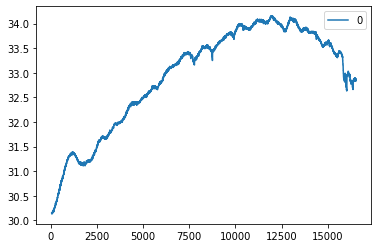

In [ ]:
TEMP.plot()

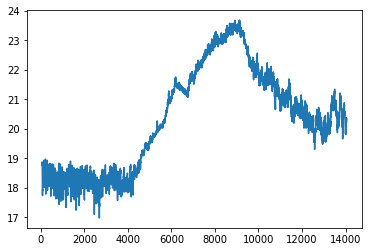

In [ ]:
HF[3].plot()

#### Q2: Can we predict the thermal vote for each subject base on the wrist band features?

##### Random forest results

In [ ]:
Cor = pd.DataFrame()
Cor["index"] = range(0,100)
Cor["F-score 1"] = 0
Cor["F-score 2"] = 0
Cor["F-score 3"] = 0
Cor["F-score 4"] = 0
Cor["F-score 5"] = 0
#Cor["correlation with ambient temp"] = 0
#Cor["correlation with body temp"] = 0

In [ ]:
Dataset.columns

Index(['EDA', 'time', 'HR', 'HR_median', 'TEMP', 'BVP', 'BVP_envelope',
       'BVP_median', 'Ambient_Temp', 'Thermal Preference'],
      dtype='object')

In [ ]:
for k in range(20,83):
  try:
    Dataset = merge(k)
    features = Dataset
    X = features[['BVP_median','HR_median']]
    y = features['Thermal Preference']
    y = y.round()

    #Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

    #Create a Gaussian Classifier
    clf=RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)

    y_pred=clf.predict(X_test)
    score = cross_val_score(clf, X, y, cv=5)
    Cor.iloc[k,1] = score[0]
    Cor.iloc[k,2] = score[1]
    Cor.iloc[k,3] = score[2]
    Cor.iloc[k,4] = score[3]
    Cor.iloc[k,5] = score[4]
  except:
    print('there is an error on ',str(k)+"_Env")
    pass

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_split

there is an error on  24_Env


/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


there is an error on  27_Env


/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


there is an error on  30_Env


/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


there is an error on  34_Env


/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are n

there is an error on  48_Env
there is an error on  49_Env


/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are n

there is an error on  60_Env
there is an error on  61_Env
there is an error on  62_Env


/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


there is an error on  64_Env


/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_split

there is an error on  80_Env
there is an error on  81_Env
there is an error on  82_Env


In [ ]:
Cor["F-score"] = (Cor["F-score 1"] + Cor["F-score 2"] + Cor["F-score 3"] + Cor["F-score 4"] + Cor["F-score 5"])/5
Cor = Cor[Cor["F-score 1"] != 0]
Cor.columns = ['Subject', 'F-score 1', 'F-score 2', 'F-score 3', 'F-score 4', 'F-score 5', 'F-score']

In [ ]:
Cor.mean()

Subject      50.220000
F-score 1     0.648408
F-score 2     0.835907
F-score 3     0.828778
F-score 4     0.758621
F-score 5     0.640385
F-score       0.742420
dtype: float64

In [ ]:
Subjects = pd.read_excel(file_name + "Subjects_all.xlsx")
Subjects = Cor.merge(Subjects, on = "Subject")
Subjects = Subjects.drop(["F-score 1","F-score 2","F-score 3","F-score 4","F-score 5"], axis = 1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

In [ ]:
Subjects = pd.DataFrame(Subjects)

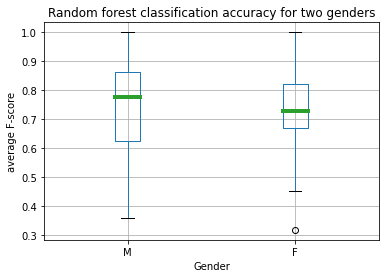

In [ ]:
M = Subjects["F-score"][Subjects["Gender"] == "M"]
F = Subjects["F-score"][Subjects["Gender"] == "F"]
df = pd.concat([M,F], axis = 1)
df.columns = ["M", "F"]
medianprops = dict(linestyle='-', linewidth=4)
df.boxplot(medianprops=medianprops)
plt.xlabel("Gender")
plt.ylabel("average F-score")
plt.title("Random forest classification accuracy for two genders")
plt.savefig("Gender_RFC result", dpi = 1000)

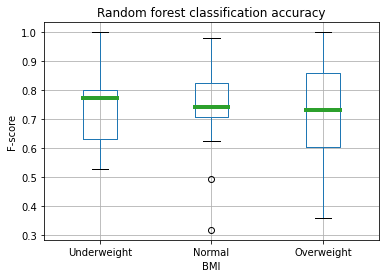

In [ ]:
Underweight = Subjects["F-score"][Subjects["BMI"] < 20]
Normal = Subjects["F-score"][(Subjects["BMI"] > 20) & (Subjects["BMI"] < 24)]
Overweight = Subjects["F-score"][(Subjects["BMI"] > 24)]
df = pd.concat([Underweight,Normal, Overweight], axis = 1)
df.columns = ["Underweight","Normal", "Overweight"]
medianprops = dict(linestyle='-', linewidth=4)
df.boxplot(medianprops=medianprops)
plt.xlabel("BMI")
plt.ylabel("F-score")
plt.title("Random forest classification accuracy")
plt.savefig("BMI", dpi = 1000)

##### predicting with BMI

In [ ]:
Subjects = pd.read_excel(file_name + "Subjects.xlsx")
Subjects["TEMP_mean"] = 0.00
Subjects["TEMP_sd"] = 0.00

Subjects["EDA_mean"] = 0.00
Subjects["EDA_sd"] = 0.00

Subjects["HR_mean"] = 0.00
Subjects["HR_sd"] = 0.00
Subjects["HR_median_mean"] = 0.00
Subjects["HR_median_sd"] = 0.00

Subjects["BVP_mean"] = 0.00
Subjects["BVP_sd"] = 0.00
Subjects["BVP_median_mean"] = 0.00
Subjects["BVP_median_sd"] = 0.00
Subjects["BVP_envelope_mean"] = 0.00
Subjects["BVP_envelope_sd"] = 0.00

Subjects["Ambient_mean"] = 0.00
Subjects["Ambient_sd"] = 0.00

Subjects["TV_mean"] = 0.00
Subjects["TV_sd"] = 0.00

In [ ]:
for k in range(0,62):
  try:
    Dataset = merge(Subjects["Subject"][k])
    Subjects["TEMP_mean"][k] = Dataset["TEMP"].mean()
    Subjects["TEMP_sd"][k] = Dataset["TEMP"].std()

    Subjects["EDA_mean"][k] = Dataset["EDA"].mean()
    Subjects["EDA_sd"][k] = Dataset["EDA"].std()

    Subjects["HR_mean"][k] = Dataset["HR"].mean()
    Subjects["HR_sd"][k] = Dataset["HR"].std()
    Subjects["HR_median_mean"][k] = Dataset["HR_median"].mean()
    Subjects["HR_median_sd"][k] = Dataset["HR_median"].std()

    Subjects["BVP_mean"][k] = Dataset["BVP"].mean()
    Subjects["BVP_sd"][k] = Dataset["BVP"].std()
    Subjects["BVP_median_mean"][k] = Dataset["BVP_median"].mean()
    Subjects["BVP_median_sd"][k] = Dataset["BVP_median"].std()
    Subjects["BVP_envelope_mean"][k] = Dataset["BVP_envelope"].mean()
    Subjects["BVP_envelope_sd"][k] = Dataset["BVP_envelope"].std()

    Subjects["Ambient_mean"][k] = Dataset["Ambient_Temp"].mean()
    Subjects["Ambient_sd"][k] = Dataset["Ambient_Temp"].std()

    Subjects["TV_mean"][k] = Dataset["Thermal Preference"].mean()
    Subjects["TV_sd"][k] = Dataset["Thermal Preference"].std()
   
  except:
    print('there is an error on ',str(k)+"_Env")
    pass

In [ ]:
Subjects = Subjects[Subjects["BVP_sd"] != 0]
Subjects = pd.DataFrame(Subjects)

In [ ]:
Subjects.head()

,Subject,Gender,BMI,TEMP_mean,TEMP_sd,EDA_mean,EDA_sd,HR_mean,HR_sd,HR_median_mean,HR_median_sd,BVP_mean,BVP_sd,BVP_median_mean,BVP_median_sd,BVP_envelope_mean,BVP_envelope_sd,Ambient_mean,Ambient_sd,TV_mean,TV_sd
0,21,M,18.651020,28.965841,0.508648,0.129326,0.051434,70.576103,3.866593,70.437654,2.842969,16.514849,8.750986,1.695490,0.649095,134.154819,101.031795,24.319468,2.104984,4.763298,0.424929
1,22,M,21.299342,31.531031,0.500686,0.349670,0.197496,91.290550,4.292269,91.430827,2.634915,14.516196,4.020747,1.804179,0.459924,73.455801,33.859812,24.729145,1.941309,-1.055377,1.232990
2,23,F,22.594123,28.765237,0.493172,13.577684,0.849661,85.657987,5.503579,86.350899,1.899790,19.430506,11.693655,1.965039,0.806237,149.969829,112.947575,22.556619,2.457014,0.511267,0.623908
5,26,M,22.375579,34.430213,0.424594,0.208693,0.038734,88.732471,3.840530,88.422110,1.723989,49.256567,15.669830,5.952780,2.346608,259.712784,102.239909,25.238872,2.359026,-1.101624,1.463342
7,28,M,25.102162,28.784802,0.828086,0.274846,0.097161,67.576968,2.253266,67.489889,1.295132,15.167637,2.792715,3.541849,0.732038,71.547866,22.503847,22.811263,3.024662,2.254908,1.560491


In [ ]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score

# X = Subjects[['HR_median_sd','BVP_median_mean','BVP_median_sd','TEMP_mean',"BMI"]]
# y = Subjects['TV_mean']

# #Split dataset into training set and test set
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# regressor = LinearRegression()  
# regressor.fit(X_train, y_train) #training the algorithm

# y_pred = regressor.predict(X_test)

# r2_score(y_test, y_pred)


import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

X = Subjects[['BVP_median_sd','TEMP_mean',"BMI"]]
y = Subjects['TV_mean']

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

#### Q3: Do we see changes in different groups of people? Can we generalize across groups?

##### Clustering timeseries

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# distortions = []
# for i in range(1, 8):
#     km = KMeans(n_clusters=i)
#     km.fit(Data_Temp)
#     distortions.append(km.inertia_)
# plt.plot(range(1, 8), distortions, marker='o')
# plt.xlabel('Number of clusters')
# plt.ylabel('Distortion')
# #plt.savefig("distortion.png")

In [ ]:
Data_Temp = pd.DataFrame()
subjects = []

In [ ]:
i = 1
for k in range(20,83):
  try:
   # plt.plot(merge(k)["EDA"])
    Data_Temp[i] = merge(k)["BVP_median"]
    subjects.append(k)
    i = i + 1
  except:
    print('there is an error on ',str(k)+"_Env")
    pass

In [ ]:
Data_Temp = Data_Temp.dropna()
Data_Temp = Data_Temp.transpose()

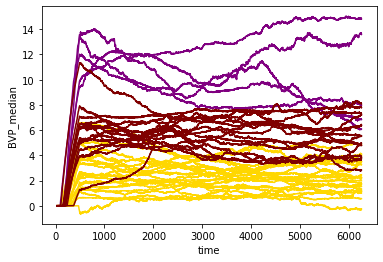

In [ ]:
n_clusters=3
kmeans = KMeans(n_clusters)
kmeans.fit(Data_Temp)

labels = kmeans.predict(Data_Temp)

colour_array = ["gold","purple","maroon","blue","red"]
for c in range(0,n_clusters):
  list_of_indices = list(filter(lambda i: labels[i]==c, range(len(labels))))
  for j in range(0,len(list_of_indices)):
    plt.plot(Data_Temp.iloc[list_of_indices[j]],color = colour_array[c])

plt.xlabel('time')
plt.ylabel('BVP_median')
plt.savefig('clustring_temperature.png', dpi = 1000)

In [ ]:
Cluster_Number = pd.concat([pd.DataFrame(subjects),pd.DataFrame(labels)], axis = 1)
Cluster_Number.columns = ["Subject", "label"]

In [ ]:
for count in range(18,32,2):
  All_Numbers = pd.DataFrame()
  starttime = count
  endtime = count + 2

  c=0
  Cluster_group = Cluster_Number["Subject"][Cluster_Number["label"] == c]
  Numbers0 = pd.DataFrame()
  for i in range(0, Cluster_group.shape[0]):
    Dataset = merge(Cluster_group.iloc[i])
    temp = Dataset["Thermal Preference"][(Dataset["Ambient_Temp"] >= starttime) & (Dataset["Ambient_Temp"] < endtime)]
    Numbers0 = pd.concat([Numbers0,temp])
  Numbers0.columns = ["0"]
  All_Numbers = pd.concat([All_Numbers, Numbers0])


  c=2
  Cluster_group = Cluster_Number["Subject"][Cluster_Number["label"] == c]
  Numbers0 = pd.DataFrame()
  for i in range(0, Cluster_group.shape[0]):
    Dataset = merge(Cluster_group.iloc[i])
    temp = Dataset["Thermal Preference"][(Dataset["Ambient_Temp"] >= starttime) & (Dataset["Ambient_Temp"] < endtime)]
    Numbers0 = pd.concat([Numbers0,temp])
  Numbers0.columns = ["1"]
  All_Numbers = pd.concat([All_Numbers, Numbers0])

  c=1
  Cluster_group = Cluster_Number["Subject"][Cluster_Number["label"] == c]
  Numbers0 = pd.DataFrame()
  for i in range(0, Cluster_group.shape[0]):
    Dataset = merge(Cluster_group.iloc[i])
    temp = Dataset["Thermal Preference"][(Dataset["Ambient_Temp"] >= starttime) & (Dataset["Ambient_Temp"] < endtime)]
    Numbers0 = pd.concat([Numbers0,temp])
  Numbers0.columns = ["2"]
  All_Numbers = pd.concat([All_Numbers, Numbers0])

  All_Numbers.boxplot(showmeans=True)
  plt.xlabel("Clusters Number for temperature between:" + str(starttime)  + '-' + str(endtime))
  plt.ylabel("Thermal Vote")
  plt.title("Boxplot for clustring BVP_median")
  plt.savefig("Cluster" + str(starttime) + str(endtime) + "_temp.png", dpi = 1000)
  plt.close()

##### BMI and gender

In [ ]:
Subjects = pd.read_excel(file_name + "Subjects.xlsx")

In [ ]:
Subjects = pd.DataFrame(Subjects)

In [ ]:
Underweight = Subjects["Subject"][Subjects["BMI"] < 20]
Normal = Subjects["Subject"][(Subjects["BMI"] > 20) & (Subjects["BMI"] < 24)]
Overweight = Subjects["Subject"][(Subjects["BMI"] > 24)]

In [ ]:
All_Numbers = pd.DataFrame()

############################################UnderWeight
Numbers0 = pd.DataFrame()
for i in range(0, Underweight.shape[0]):
  try:
    Dataset = merge(Underweight.iloc[i])
    Numbers0 = pd.concat([Numbers0,Dataset["Thermal Preference"]])
  except:
    print('there is an error on ' + str(i) + " in this subject:" + str(Underweight.iloc[i]))  
    pass
Numbers0.columns = ["Underweight"]
All_Numbers = pd.concat([All_Numbers, Numbers0])

############################################Normal
Numbers0 = pd.DataFrame()
for i in range(0, Normal.shape[0]):
  try:
    Dataset = merge(Normal.iloc[i])
    Numbers0 = pd.concat([Numbers0,Dataset["Thermal Preference"]])
  except:
    print('there is an error on ' + str(i) + " in this subject:" + str(Normal.iloc[i]))  
    pass
Numbers0.columns = ["Normal"]
All_Numbers = pd.concat([All_Numbers, Numbers0])

############################################Overweight
Numbers0 = pd.DataFrame()
for i in range(0, Overweight.shape[0]):
  try:
    Dataset = merge(Overweight.iloc[i])
    Numbers0 = pd.concat([Numbers0,Dataset["Thermal Preference"]])
  except:
    print('there is an error on ' + str(i) + " in this subject:" + str(Overweight.iloc[i]))  
    pass
Numbers0.columns = ["Overweight"]
All_Numbers = pd.concat([All_Numbers, Numbers0])

In [ ]:
All_Numbers.boxplot(showmeans=True)
plt.xlabel("Group of people based on BMI")
plt.ylabel("Thermal Vote")
plt.title("Boxplot thermal preference for different group of people")
plt.savefig("BMI_Thermal vote.png", dpi = 1000)

In [ ]:
#classifying based on Gender
M = Subjects["Subject"][Subjects["Gender"] == "M"]
F = Subjects["Subject"][Subjects["Gender"] == "F"]

In [ ]:
M.iloc[i]

48

In [ ]:
All_Numbers = pd.DataFrame()

############################################UnderWeight
Numbers0 = pd.DataFrame()
for i in range(0, M.shape[0]):
  try:
    Dataset = merge(M.iloc[i])
    Numbers0 = pd.concat([Numbers0,Dataset["Thermal Preference"]])
  except:
    print('there is an error on ' + str(i) + " in this subject:" + str(Underweight.iloc[i]))  
    pass
Numbers0.columns = ["M"]
All_Numbers = pd.concat([All_Numbers, Numbers0])

############################################Normal
Numbers0 = pd.DataFrame()
for i in range(0, F.shape[0]):
  try:
    Dataset = merge(F.iloc[i])
    Numbers0 = pd.concat([Numbers0,Dataset["Thermal Preference"]])
  except:
    print('there is an error on ' + str(i) + " in this subject:" + str(Normal.iloc[i]))  
    pass
Numbers0.columns = ["F"]
All_Numbers = pd.concat([All_Numbers, Numbers0])

In [ ]:
All_Numbers.boxplot()
plt.xlabel("Gender")
plt.ylabel("F-score")
plt.title("Random forest classification accuracy")
plt.savefig("Gender", dpi = 1000)

#### Clustring the whole dataset Scalar vector together

##### clustring step

In [ ]:
from sklearn.cluster import KMeans
from random import seed
from random import random

In [ ]:
Subjects = pd.read_excel(file_name + "Subjects_all.xlsx")

In [ ]:
Data_Temp = pd.DataFrame()
Data_Temp["temp_index"] = range(0,25)
subjects = []

In [ ]:
i = 1
for k in range(20,83):
  try:
    Dataset = merge(k)
    Dataset = Dataset[Dataset.index < 25]

    BMI = [];
    BMI += 25 * [Subjects["BMI"][Subjects["Subject"] == k]]
    BMI = pd.DataFrame(BMI)
    BMI.columns = ["BMI"]

    # Height = [];
    # Height += 25 * [Subjects["Height"][Subjects["Subject"] == k]]
    # Height = pd.DataFrame(Height)
    # Height.columns = ["Height"]

    # Weight = [];
    # Weight += 25 * [Subjects["Weight"][Subjects["Subject"] == k]]
    # Weight = pd.DataFrame(Weight)
    # Weight.columns = ["Weight"]

    # Gender = []
    # Gender += 25 * [Subjects["Gender"][Subjects["Subject"] == k]]
    # Gender = pd.DataFrame(Gender)
    # Gender.columns = ["Gender"]
    # Gender["Gender"][Gender["Gender"] == 'M'] = 1
    # Gender["Gender"][Gender["Gender"] == 'F'] = 0

    Data_Temp[i] = -10000
    # Data_Temp[i][0:25] = Dataset["TEMP"]
    # Data_Temp[i][50:75] = Dataset["HR_median"]
    # Data_Temp[i][25:50] = Dataset["BVP_median"]
    Data_Temp[i][0:25] = BMI["BMI"]
    # Data_Temp[i][25:50] = Dataset["HR_median"]
    # Data_Temp[i][50:75] = Dataset["BVP_median"]
    # Data_Temp[i][100:125] = Weight["Weight"]
    # Data_Temp[i][125:150] = Height["Height"]
    # Data_Temp[i][150:175] = Gender["Gender"]

    subjects.append(k)
    i = i + 1
  except:
    print('there is an error on ',str(k)+"_Env")
    pass

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


there is an error on  24_Env
there is an error on  27_Env
there is an error on  30_Env
there is an error on  34_Env
there is an error on  48_Env
there is an error on  49_Env
there is an error on  60_Env
there is an error on  61_Env
there is an error on  62_Env
there is an error on  64_Env
there is an error on  80_Env
there is an error on  81_Env
there is an error on  82_Env


In [ ]:
Data_Temp = Data_Temp.dropna()
Data_Temp = Data_Temp.transpose()
Data_Temp = Data_Temp.drop("temp_index")

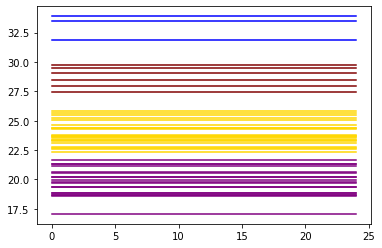

In [ ]:
n_clusters = 4
kmeans = KMeans(n_clusters)
kmeans.fit(Data_Temp)

labels = kmeans.predict(Data_Temp)

colour_array = ["gold","purple","maroon","blue","red"]
for c in range(0,n_clusters):
  list_of_indices = list(filter(lambda i: labels[i]==c, range(len(labels))))
  for j in range(0,len(list_of_indices)):
    plt.plot(Data_Temp.iloc[list_of_indices[j]],color = colour_array[c])

#plt.savefig('clustring_temperature.png', dpi = 1000)

In [ ]:
labels

array([1, 1, 1, 0, 1, 0, 0, 3, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 2, 1,
       2, 3, 0, 2, 2, 1, 1, 1, 0, 1, 0, 2, 0, 3, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 2, 1], dtype=int32)

##### Combining and plotting

In [ ]:
Cluster_Number = pd.concat([pd.DataFrame(subjects),pd.DataFrame(labels)], axis = 1)
Cluster_Number.columns = ["Subject", "label"]

In [ ]:
# for count in range(18,30,2):
#   All_Numbers = pd.DataFrame()
#   starttime = count
#   endtime = count + 2

#   c=3
#   Cluster_group = Cluster_Number["Subject"][Cluster_Number["label"] == c]
#   Numbers0 = pd.DataFrame()
#   for i in range(0, Cluster_group.shape[0]):
#     Dataset = merge(Cluster_group.iloc[i])
#     temp = Dataset["Thermal Preference"][(Dataset["Ambient_Temp"] >= starttime) & (Dataset["Ambient_Temp"] < endtime)]
#     Numbers0 = pd.concat([Numbers0,temp])
#   Numbers0.columns = ["0"]
#   All_Numbers = pd.concat([All_Numbers, Numbers0])


#   c=1
#   Cluster_group = Cluster_Number["Subject"][Cluster_Number["label"] == c]
#   Numbers0 = pd.DataFrame()
#   for i in range(0, Cluster_group.shape[0]):
#     Dataset = merge(Cluster_group.iloc[i])
#     temp = Dataset["Thermal Preference"][(Dataset["Ambient_Temp"] >= starttime) & (Dataset["Ambient_Temp"] < endtime)]
#     Numbers0 = pd.concat([Numbers0,temp])
#   Numbers0.columns = ["1"]
#   All_Numbers = pd.concat([All_Numbers, Numbers0])

#   c=0
#   Cluster_group = Cluster_Number["Subject"][Cluster_Number["label"] == c]
#   Numbers0 = pd.DataFrame()
#   for i in range(0, Cluster_group.shape[0]):
#     Dataset = merge(Cluster_group.iloc[i])
#     temp = Dataset["Thermal Preference"][(Dataset["Ambient_Temp"] >= starttime) & (Dataset["Ambient_Temp"] < endtime)]
#     Numbers0 = pd.concat([Numbers0,temp])
#   Numbers0.columns = ["2"]
#   All_Numbers = pd.concat([All_Numbers, Numbers0])

#   c=2
#   Cluster_group = Cluster_Number["Subject"][Cluster_Number["label"] == c]
#   Numbers0 = pd.DataFrame()
#   for i in range(0, Cluster_group.shape[0]):
#     Dataset = merge(Cluster_group.iloc[i])
#     temp = Dataset["Thermal Preference"][(Dataset["Ambient_Temp"] >= starttime) & (Dataset["Ambient_Temp"] < endtime)]
#     Numbers0 = pd.concat([Numbers0,temp])
#   Numbers0.columns = ["3"]
#   All_Numbers = pd.concat([All_Numbers, Numbers0])
  
#   medianprops = dict(linestyle='-', linewidth=4)
#   All_Numbers.boxplot(medianprops=medianprops)

#   plt.xlabel("Clusters Number for temperature between:" + str(starttime)  + '-' + str(endtime))
#   plt.ylabel("Thermal Vote")
#   plt.savefig("Cluster" + str(starttime) + str(endtime) + "_temp.png", dpi = 1000)
#   plt.close()

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to 

##### comparing the prediction power of clusters

In [ ]:
c=0
Cluster_group = Cluster_Number["Subject"][Cluster_Number["label"] == c]
Dataset0 = pd.DataFrame()
for i in range(0, Cluster_group.shape[0]):
  Dataset = merge(Cluster_group.iloc[i])
  Dataset0 = pd.concat([Dataset0,Dataset])

c=1
Cluster_group = Cluster_Number["Subject"][Cluster_Number["label"] == c]
Dataset1 = pd.DataFrame()
for i in range(0, Cluster_group.shape[0]):
  Dataset = merge(Cluster_group.iloc[i])
  Dataset1 = pd.concat([Dataset1,Dataset])

c=2
Cluster_group = Cluster_Number["Subject"][Cluster_Number["label"] == c]
Dataset2 = pd.DataFrame()
for i in range(0, Cluster_group.shape[0]):
  Dataset = merge(Cluster_group.iloc[i])
  Dataset2 = pd.concat([Dataset2,Dataset])

c=3
Cluster_group = Cluster_Number["Subject"][Cluster_Number["label"] == c]
Dataset3 = pd.DataFrame()
for i in range(0, Cluster_group.shape[0]):
  Dataset = merge(Cluster_group.iloc[i])
  Dataset3 = pd.concat([Dataset3,Dataset])

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


In [ ]:
independentVar = ['Ambient_Temp']

features = Dataset0
X = features[independentVar]
y = features['Thermal Preference']
y = y.round()

#Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
score0 = cross_val_score(clf, X, y, cv=5)

features = Dataset1
X = features[independentVar]
y = features['Thermal Preference']
y = y.round()

#Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
score1 = cross_val_score(clf, X, y, cv=5)

features = Dataset2
X = features[independentVar]
y = features['Thermal Preference']
y = y.round()

#Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
score2 = cross_val_score(clf, X, y, cv=5)

features = Dataset3
X = features[independentVar]
y = features['Thermal Preference']
y = y.round()

#Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)
score3 = cross_val_score(clf, X, y, cv=5)

In [ ]:
(score0.mean() + score1.mean() + score2.mean() + score3.mean())/3

0.5719172268088643

In [ ]:
labels

array([2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 0, 2, 2, 1, 1, 1, 0, 1, 2, 0, 0, 2,
       0, 0, 0, 0, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 2, 2, 0, 2, 1, 2, 2, 2,
       0, 0, 0, 1, 2, 1], dtype=int32)

#### predicting based on previous observations

##### Dataset Preparation

In [ ]:
Dataset = merge(54)
timestep = 5
Dataset["Thermal Preference"] = Dataset["Thermal Preference"].round()
Dataset["time"] = Dataset.index

# Moving Up thermal preference for 5 minutes
TV = Dataset["Thermal Preference"][timestep:Dataset.shape[0]]
TV = TV.reset_index()
TV = TV.drop("index", axis = 1)

#substitution
Dataset = Dataset.drop("Thermal Preference", axis = 1)
Dataset["Thermal Preference"] = TV["Thermal Preference"]
Dataset = Dataset[Dataset["time"] < (Dataset.shape[0]-timestep)]

##### Predicting based on previous datapoints

In [ ]:
import pandas as pd
import numpy as np
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

In [ ]:
Cor = pd.DataFrame()
Cor["index"] = range(0,100)
Cor["R2"] = 0

In [ ]:
for k in range(20,83):
  try:
    Dataset = merge(k)
    timestep = 5
    Dataset["Thermal Preference"] = Dataset["Thermal Preference"].round()
    Dataset["time"] = Dataset.index

    # Moving Up thermal preference for 5 minutes
    TV = Dataset["Thermal Preference"][timestep:Dataset.shape[0]]
    TV = TV.reset_index()
    TV = TV.drop("index", axis = 1)

    #substitution
    Dataset = Dataset.drop("Thermal Preference", axis = 1)
    Dataset["Thermal Preference"] = TV["Thermal Preference"]
    Dataset = Dataset[Dataset["time"] < (Dataset.shape[0]-timestep)]

    X = Dataset[['EDA']]
    y = Dataset['Thermal Preference']

    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    Cor.iloc[k,1] = est2.rsquared
  except:
    print('there is an error on ',str(k)+"_Env")
    pass

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


there is an error on  24_Env
there is an error on  27_Env


/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


there is an error on  30_Env
there is an error on  34_Env
there is an error on  48_Env
there is an error on  49_Env
there is an error on  60_Env
there is an error on  61_Env
there is an error on  62_Env
there is an error on  64_Env
there is an error on  80_Env
there is an error on  81_Env
there is an error on  82_Env


In [ ]:
Cor[Cor["R2"] > 0].mean()

index    51.489362
R2        0.378926
dtype: float64

In [ ]:
Subjects = pd.read_excel(file_name + "Subjects_all.xlsx")
Subjects = Cor.merge(Subjects, on = "Subject")
Subjects = Subjects.drop(["F-score 1","F-score 2","F-score 3","F-score 4","F-score 5"], axis = 1)

In [ ]:
Subjects = pd.DataFrame(Subjects)

In [ ]:
M = Subjects["F-score"][Subjects["Gender"] == "M"]
F = Subjects["F-score"][Subjects["Gender"] == "F"]
df = pd.concat([M,F], axis = 1)
df.columns = ["M", "F"]
df.boxplot()
plt.xlabel("Gender")
plt.ylabel("average F-score")
plt.title("Random forest classification accuracy for two genders")
#plt.savefig("Gender", dpi = 1000)

In [ ]:
Underweight = Subjects["F-score"][Subjects["BMI"] < 20]
Normal = Subjects["F-score"][(Subjects["BMI"] > 20) & (Subjects["BMI"] < 24)]
Overweight = Subjects["F-score"][(Subjects["BMI"] > 24)]
df = pd.concat([Underweight,Normal, Overweight], axis = 1)
df.columns = ["Underweight","Normal", "Overweight"]

In [ ]:
df.boxplot()
plt.xlabel("BMI")
plt.ylabel("F-score")
plt.title("Random forest classification accuracy")
#plt.savefig("BMI", dpi = 1000)

##### Random Forest Classification results

In [ ]:
Cor = pd.DataFrame()
Cor["index"] = range(0,100)
Cor["F-score 1"] = 0
Cor["F-score 2"] = 0
Cor["F-score 3"] = 0
Cor["F-score 4"] = 0
Cor["F-score 5"] = 0
#Cor["correlation with ambient temp"] = 0
#Cor["correlation with body temp"] = 0

In [ ]:
for k in range(20,83):
  try:
    Dataset = merge(k)
    timestep = 5
    Dataset["Thermal Preference"] = Dataset["Thermal Preference"].round()
    Dataset["time"] = Dataset.index

    # Moving Up thermal preference for 5 minutes
    TV = Dataset["Thermal Preference"][timestep:Dataset.shape[0]]
    TV = TV.reset_index()
    TV = TV.drop("index", axis = 1)

    #substitution
    Dataset = Dataset.drop("Thermal Preference", axis = 1)
    Dataset["Thermal Preference"] = TV["Thermal Preference"]
    Dataset = Dataset[Dataset["time"] < (Dataset.shape[0]-timestep)]

    features = Dataset
    X = features[['BVP_median','HR_median']]
    y = features['Thermal Preference']
    y = y.round()

    #Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

    #Create a Gaussian Classifier
    clf=RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)

    y_pred=clf.predict(X_test)
    score = cross_val_score(clf, X, y, cv=5)
    Cor.iloc[k,1] = score[0]
    Cor.iloc[k,2] = score[1]
    Cor.iloc[k,3] = score[2]
    Cor.iloc[k,4] = score[3]
    Cor.iloc[k,5] = score[4]
    #Cor.iloc[k,6] = np.corrcoef(Dataset["BVP"],Dataset["Thermal Preference"])[1,0]
    #Cor.iloc[k,7] = np.corrcoef(Dataset["TEMP"],Dataset["Thermal Preference"])[1,0]
  except:
    print('there is an error on ',str(k)+"_Env")
    pass

In [ ]:
Cor = Cor[Cor["F-score 1"] != 0]

In [ ]:
Cor["F-score"] = (Cor["F-score 1"] + Cor["F-score 2"] + Cor["F-score 3"] + Cor["F-score 4"] + Cor["F-score 5"])/5
Cor = Cor[Cor["F-score 1"] != 0]
Cor.columns = ['Subject', 'F-score 1', 'F-score 2', 'F-score 3', 'F-score 4', 'F-score 5', 'F-score']

In [ ]:
Cor.mean()

Subject      50.220000
F-score 1     0.716075
F-score 2     0.828766
F-score 3     0.861896
F-score 4     0.807853
F-score 5     0.704552
F-score       0.783828
dtype: float64

In [ ]:
Subjects = pd.read_excel(file_name + "Subjects_all.xlsx")
Subjects = Cor.merge(Subjects, on = "Subject")
Subjects = Subjects.drop(["F-score 1","F-score 2","F-score 3","F-score 4","F-score 5"], axis = 1)

In [ ]:
Subjects = pd.DataFrame(Subjects)

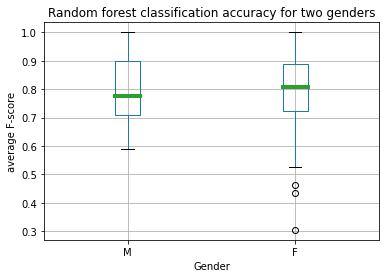

In [ ]:
M = Subjects["F-score"][Subjects["Gender"] == "M"]
F = Subjects["F-score"][Subjects["Gender"] == "F"]
df = pd.concat([M,F], axis = 1)
df.columns = ["M", "F"]
medianprops = dict(linestyle='-', linewidth=4)
df.boxplot(medianprops=medianprops)
plt.xlabel("Gender")
plt.ylabel("average F-score")
plt.title("Random forest classification accuracy for two genders")
plt.savefig("Gender", dpi = 1000)

In [ ]:
Underweight = Subjects["F-score"][Subjects["BMI"] < 20]
Normal = Subjects["F-score"][(Subjects["BMI"] > 20) & (Subjects["BMI"] < 24)]
Overweight = Subjects["F-score"][(Subjects["BMI"] > 24)]
df = pd.concat([Underweight,Normal, Overweight], axis = 1)
df.columns = ["Underweight","Normal", "Overweight"]

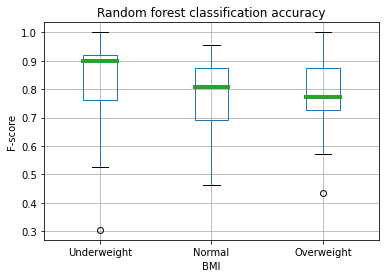

In [ ]:
medianprops = dict(linestyle='-', linewidth=4)
df.boxplot(medianprops=medianprops)
plt.xlabel("BMI")
plt.ylabel("F-score")
plt.title("Random forest classification accuracy")
plt.savefig("BMI", dpi = 1000)

### Papers plots

#### plots of BMI

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


there is an error on  24_Env
there is an error on  25_Env
there is an error on  27_Env
there is an error on  30_Env
there is an error on  32_Env
there is an error on  33_Env
there is an error on  34_Env
there is an error on  35_Env
there is an error on  48_Env
there is an error on  49_Env
there is an error on  60_Env
there is an error on  61_Env
there is an error on  62_Env
there is an error on  63_Env
there is an error on  64_Env
there is an error on  66_Env
there is an error on  69_Env
there is an error on  76_Env
there is an error on  77_Env
there is an error on  80_Env
there is an error on  81_Env
there is an error on  82_Env


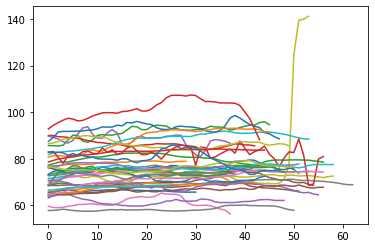

In [ ]:
subjects = []
for k in range(20,83):
  try:
    Dataset = merge(k)
    subjects.append(k)
    plt.plot(Dataset["HR_median"])
  except:
    print('there is an error on ',str(k)+"_Env")
    pass

In [ ]:
Subjects = pd.read_excel(file_name + "Subjects_all.xlsx")
subjects = pd.DataFrame(subjects)
subjects.columns = ['Subject']
Subjects = Subjects.merge(subjects, how = 'inner')

In [ ]:
Subjects.shape

(39, 6)

In [ ]:
plt.plot(Subjects['Height'], Subjects['Weight'], 'o')
plt.xlabel("Height(in)")
plt.ylabel("Weight(lb)")
plt.savefig("Subjects Weight and height", dpi = 1000)

#### Plotting all features without any filtering

In [ ]:
k=75

fig, ax = plt.subplots(3,2)

HR = pd.read_csv(file_name + str(k) + '/HR.csv',header = None)
HR = HR.drop([0,1])
ax[0,0].plot(HR)
ax[0,0].set_title('Heart Rate')

EDA = pd.read_csv(file_name + str(k) + '/EDA.csv', header = None)
EDA = EDA.drop([0,1])
ax[0,1].plot(EDA)
ax[0,1].set_title("ElectroDermal Activity")

TEMP = pd.read_csv(file_name + str(k) + '/TEMP.csv', header = None)
TEMP = TEMP.drop([0,1])
TEMP = TEMP[0][TEMP[0] < 50]
ax[1,0].plot(TEMP)
ax[1,0].set_title("Skin Temperature")

BVP = pd.read_csv(file_name + str(k) + '/BVP.csv', header = None)
BVP = BVP.drop([0,1])
plt.legend([])
ax[1,1].plot(BVP)
ax[1,1].set_title("Blood Volume Pulse")

Ambient = pd.read_csv(file_name1 + str(k) + '_Env_1.txt',sep = ' ',header = None)
ax[2,0].plot(Ambient[3])
ax[2,0].set_title("Ambient Temperature")

TV = pd.read_csv(file_name + str(k) + '/' + str(k) + '_votes&ambient.csv')
TV["time"] = TV["Unnamed: 0"]*2
TV = TV.drop(["Time", "Unnamed: 0"],axis=1)
ax[2,1].plot(TV["Thermal Preference"])
ax[2,1].set_title("Thermal Preference")

fig.tight_layout()
plt.savefig("Raw_Data.png", dpi = 1000)

#### plotting cleared datasets

In [ ]:
k=75
EDA = pd.read_csv(file_name + str(k) + '/EDA_envelope.csv', header = None)

In [ ]:
EDA.head()

,0
0,0.016066
1,0.016205
2,0.016345
3,0.016485
4,0.016624


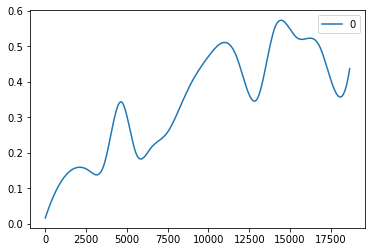

In [ ]:
EDA.plot()

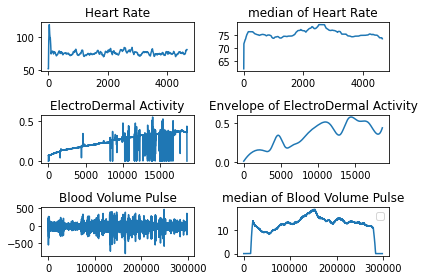

In [ ]:
k=75

fig, ax = plt.subplots(3,2)

HR = pd.read_csv(file_name + str(k) + '/HR.csv',header = None)
HR = HR.drop([0,1])
ax[0,0].plot(HR)
ax[0,0].set_title('Heart Rate')

HR = pd.read_csv(file_name + str(k) + '/HR_median.csv',header = None)
HR = HR.drop([0,1,2,3,4,5,6])
ax[0,1].plot(HR)
ax[0,1].set_title('median of Heart Rate')

#################
EDA = pd.read_csv(file_name + str(k) + '/EDA.csv', header = None)
EDA = EDA.drop([0,1])
ax[1,0].plot(EDA)
ax[1,0].set_title("ElectroDermal Activity")

EDA = pd.read_csv(file_name + str(k) + '/EDA_envelope.csv', header = None)
EDA = EDA.drop([0,1])
ax[1,1].plot(EDA)
ax[1,1].set_title("Envelope of ElectroDermal Activity")

##################
BVP = pd.read_csv(file_name + str(k) + '/BVP.csv', header = None)
BVP = BVP.drop([0,1])
plt.legend([])
ax[2,0].plot(BVP)
ax[2,0].set_title("Blood Volume Pulse")

BVP = pd.read_csv(file_name + str(k) + '/BVP_median.csv', header = None)
BVP = BVP.drop([0,1])
plt.legend([])
ax[2,1].plot(BVP)
ax[2,1].set_title("median of Blood Volume Pulse")

fig.tight_layout()
plt.savefig("cleaned_Datas.png", dpi = 1000)

#### all ambient temperature

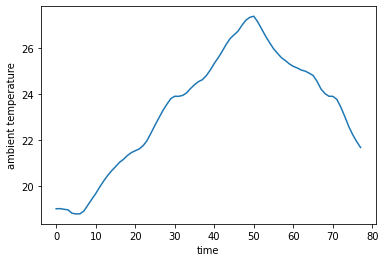

In [ ]:
k=75
Ambient = pd.read_csv(file_name1 + str(k) + '_Env_1.txt',sep = ' ',header = None)
Ambient = Ambient.groupby(np.arange(len(Ambient[3]))//30).mean()
Ambient[3].plot()
plt.xlabel("time")
plt.ylabel("ambient temperature")
plt.savefig("ambient temperature.png", dpi = 1000)

#### Comparing ambient temperature and skin temperature

In [ ]:
All_Numbers_Temp = pd.DataFrame()
All_Numbers_Ambient = pd.DataFrame()

for k in range(20,83):
  try:
    Ambient = pd.read_csv(file_name1 + str(k) + '_Env_1.txt',sep = ' ',header = None)

    TEMP = pd.read_csv(file_name + str(k) + '/TEMP.csv', header = None)
    TEMP = TEMP.drop([0,1])
    TEMP = TEMP[0][TEMP[0] < 50]

    All_Numbers_Temp = pd.concat([All_Numbers_Temp, TEMP])
    All_Numbers_Ambient = pd.concat([All_Numbers_Ambient, Ambient[3]])

  except:
    print('there is an error on ',str(k)+"_Env")
    pass

In [ ]:
pd.concat([All_Numbers_Temp,All_Numbers_Ambient], axis = 1)

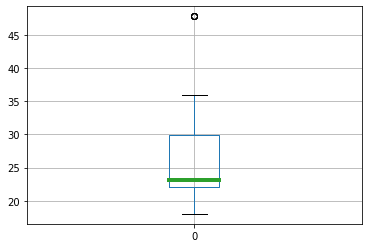

In [ ]:
medianprops = dict(linestyle='-', linewidth=4)
All_Numbers_Temp.boxplot(medianprops=medianprops)
# plt.xlabel("Clusters Number for temperature between:" + str(starttime)  + '-' + str(endtime))
# plt.ylabel("Thermal Vote")
# plt.title("Boxplot for clustring BMI and skin temperature")
# plt.savefig("Cluster" + str(starttime) + str(endtime) + "_temp.png", dpi = 1000)
# plt.close()

#### BMI and Gender Charts

In [ ]:
Subjects = pd.read_excel(file_name + "Subjects_all.xlsx")

In [ ]:
Subjects = pd.DataFrame(Subjects)

In [ ]:
Underweight = Subjects["Subject"][Subjects["BMI"] < 20]
Normal = Subjects["Subject"][(Subjects["BMI"] > 20) & (Subjects["BMI"] < 24)]
Overweight = Subjects["Subject"][(Subjects["BMI"] > 24)]

In [ ]:
All_Numbers = pd.DataFrame()
feature = "Thermal Preference"
############################################UnderWeight
Numbers0 = pd.DataFrame()
for i in range(0, Underweight.shape[0]):
  try:
    Dataset = merge(Underweight.iloc[i])
    Numbers0 = pd.concat([Numbers0,Dataset[feature]])
  except:
    print('there is an error on ' + str(i) + " in this subject:" + str(Underweight.iloc[i]))  
    pass
Numbers0.columns = ["Underweight"]
All_Numbers = pd.concat([All_Numbers, Numbers0])

############################################Normal
Numbers0 = pd.DataFrame()
for i in range(0, Normal.shape[0]):
  try:
    Dataset = merge(Normal.iloc[i])
    Numbers0 = pd.concat([Numbers0,Dataset[feature]])
  except:
    print('there is an error on ' + str(i) + " in this subject:" + str(Normal.iloc[i]))  
    pass
Numbers0.columns = ["Normal"]
All_Numbers = pd.concat([All_Numbers, Numbers0])

############################################Overweight
Numbers0 = pd.DataFrame()
for i in range(0, Overweight.shape[0]):
  try:
    Dataset = merge(Overweight.iloc[i])
    Numbers0 = pd.concat([Numbers0,Dataset[feature]])
  except:
    print('there is an error on ' + str(i) + " in this subject:" + str(Overweight.iloc[i]))  
    pass
Numbers0.columns = ["Overweight"]
All_Numbers = pd.concat([All_Numbers, Numbers0])

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


there is an error on 2 in this subject:27
there is an error on 7 in this subject:49
there is an error on 11 in this subject:64
there is an error on 2 in this subject:24
there is an error on 5 in this subject:30
there is an error on 13 in this subject:61
there is an error on 16 in this subject:61
there is an error on 17 in this subject:62
there is an error on 26 in this subject:80
there is an error on 27 in this subject:81
there is an error on 3 in this subject:34
there is an error on 13 in this subject:60
there is an error on 20 in this subject:82


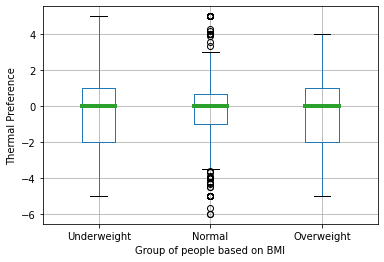

In [ ]:
medianprops = dict(linestyle='-', linewidth=4)
All_Numbers.boxplot(medianprops=medianprops)
plt.xlabel("Group of people based on BMI")
plt.ylabel(feature)
plt.savefig("BMI_" + feature + "_.png", dpi = 1000)

In [ ]:
#classifying based on Gender
M = Subjects["Subject"][Subjects["Gender"] == "M"]
F = Subjects["Subject"][Subjects["Gender"] == "F"]

In [ ]:
All_Numbers = pd.DataFrame()

############################################Males
Numbers0 = pd.DataFrame()
for i in range(0, M.shape[0]):
  try:
    Dataset = merge(M.iloc[i])
    Numbers0 = pd.concat([Numbers0,Dataset[feature]])
  except:
    print('there is an error on ' + str(i) + " in this subject:" + str(M.iloc[i]))  
    pass
Numbers0.columns = ["M"]
All_Numbers = pd.concat([All_Numbers, Numbers0])

############################################feamales
Numbers0 = pd.DataFrame()
for i in range(0, F.shape[0]):
  try:
    Dataset = merge(F.iloc[i])
    Numbers0 = pd.concat([Numbers0,Dataset[feature]])
  except:
    print('there is an error on ' + str(i) + " in this subject:" + str(F.iloc[i]))  
    pass
Numbers0.columns = ["F"]
All_Numbers = pd.concat([All_Numbers, Numbers0])

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:1097: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


there is an error on 3 in this subject:24
there is an error on 7 in this subject:30
there is an error on 19 in this subject:62
there is an error on 24 in this subject:82
there is an error on 1 in this subject:27
there is an error on 4 in this subject:34
there is an error on 11 in this subject:61
there is an error on 13 in this subject:49
there is an error on 21 in this subject:60
there is an error on 22 in this subject:61
there is an error on 24 in this subject:64
there is an error on 36 in this subject:80
there is an error on 37 in this subject:81


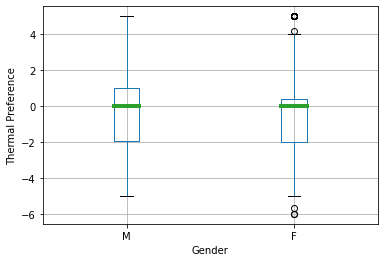

In [ ]:
medianprops = dict(linestyle='-', linewidth=4)
All_Numbers.boxplot(medianprops=medianprops)
plt.xlabel("Gender")
plt.ylabel(feature)
plt.savefig("Gender_" +feature + "_.png", dpi = 1000)